# **Import Libraries**

In [1]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=459c03cd5db40e631c490246b9c51236eb7bbcd508662c3fd5e619839bd0f82e
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [2]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
from tensorflow.keras import layers, models
import torch
from tqdm import tqdm
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
import tensorflow as tf
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
import lime
import lime.lime_tabular
from tensorflow.keras import models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input
import tensorflow as tf
import torch
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torchvision import transforms
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
import shap
import tensorflow as tf
from tensorflow.keras import models
import torch.nn.functional as F

# **Define Dataset Directories**

In [3]:
kaggle_data_path = '/content/drive/MyDrive/Machine Learning-2 [Journal Draft]/Arafat Hossain Ankon (212-25-744)/Dataset/Kaggel/'
mendeley_data_path = '/content/drive/MyDrive/Machine Learning-2 [Journal Draft]/Arafat Hossain Ankon (212-25-744)/Dataset/Mendly Dataset/'


# **Load kaggle Cancer Images**

In [4]:
cancer_images = []  # List to store cancer image arrays
cancer_image_path = os.path.join(kaggle_data_path, 'Cancer')  # Path to the 'Cancer' folder

for filename in os.listdir(cancer_image_path):
    if filename.endswith(('.jpg', '.jpeg', '.png')):  # Check if it's an image file
        img_path = os.path.join(cancer_image_path, filename)
        img = load_img(img_path)
        img_array = img_to_array(img)
        cancer_images.append(img_array)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


# **Load kaggle Non-Cancer Images**

In [5]:
non_cancer_images = []  # List to store non-cancer image arrays
non_cancer_image_path = os.path.join(kaggle_data_path, 'Non-Cancer')  # Path to the 'Non-Cancer' folder

for filename in os.listdir(non_cancer_image_path):
    if filename.endswith(('.jpg', '.jpeg', '.png')):  # Check if it's an image file
        img_path = os.path.join(non_cancer_image_path, filename)
        img = load_img(img_path)
        img_array = img_to_array(img)
        non_cancer_images.append(img_array)

# **Print Summary of Loaded Data**



In [6]:
print(f"Loaded {len(cancer_images)} cancer images")
print(f"Loaded {len(non_cancer_images)} non-cancer images")

Loaded 82 cancer images
Loaded 41 non-cancer images


# **Kaggle Data Preprocessing**

In [7]:
# Resize all images to the same shape
img_height, img_width = 224, 224  # Modify as needed

# -------------------- Image Preprocessing Function --------------------

def preprocess_image(image_path):
    image = load_img(image_path, target_size=(img_height, img_width))
    image_array = img_to_array(image)
    image_array = image_array / 255.0  # Normalize pixel values between 0 and 1
    return image_array

# -------------------- Process Cancer Images --------------------

processed_cancer_images = []
for img_path in os.listdir(cancer_image_path):  # loop through image paths directly
    if img_path.endswith(('.jpg', '.jpeg', '.png')):
        full_img_path = os.path.join(cancer_image_path, img_path)
        processed_cancer_images.append(preprocess_image(full_img_path))

# -------------------- Process Non-Cancer Images --------------------

processed_non_cancer_images = []
for img_path in os.listdir(non_cancer_image_path):  # loop through image paths directly
    if img_path.endswith(('.jpg', '.jpeg', '.png')):
        full_img_path = os.path.join(non_cancer_image_path, img_path)
        processed_non_cancer_images.append(preprocess_image(full_img_path))

# -------------------- Convert Lists to NumPy Arrays --------------------

cancer_images_array = np.array(processed_cancer_images)
non_cancer_images_array = np.array(processed_non_cancer_images)

# -------------------- Output Summary --------------------

print(f"Processed {len(cancer_images_array)} cancer images.")
print(f"Processed {len(non_cancer_images_array)} non-cancer images.")


Processed 82 cancer images.
Processed 41 non-cancer images.


# **Kaggle Data Augmentation**

In [8]:
# ============================
# Create ImageDataGenerator for Augmentation
# ============================
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# ============================
# Define Image Augmentation Function
# ============================
def augment_images(image_array, batch_size=1, num_augmented_images=5):
    # Reshape the image array to (batch_size, height, width, channels)
    image_array = image_array.reshape((1, img_height, img_width, 3))  # Reshape for augmentation
    augmented_images = []

    # Generate augmented images
    augmented_batch = datagen.flow(image_array, batch_size=batch_size)
    for augmented_image in augmented_batch:
        augmented_image = augmented_image[0].astype('float32')
        augmented_images.append(augmented_image)
        if len(augmented_images) == num_augmented_images:
            break  # Stop after generating the desired number of augmented images

    return np.array(augmented_images)

# ============================
# Augment Cancer Images
# ============================
augmented_cancer_images = []
for img_array in cancer_images_array:
    augmented_cancer_images.extend(augment_images(img_array, batch_size=1, num_augmented_images=5))

# ============================
# Augment Non-Cancer Images
# ============================
augmented_non_cancer_images = []
for img_array in non_cancer_images_array:
    augmented_non_cancer_images.extend(augment_images(img_array, batch_size=1, num_augmented_images=5))

# ============================
# Convert to NumPy Arrays
# ============================
augmented_cancer_images = np.array(augmented_cancer_images)
augmented_non_cancer_images = np.array(augmented_non_cancer_images)

# ============================
# Display Summary
# ============================
print(f"Generated {len(augmented_cancer_images)} augmented cancer images.")
print(f"Generated {len(augmented_non_cancer_images)} augmented non-cancer images.")


Generated 410 augmented cancer images.
Generated 205 augmented non-cancer images.


# **Mendely Dataset**

In [9]:
# --------------------------- #
# Define Image Preprocessing Function
# --------------------------- #
def preprocess_image(image_path):
    image = load_img(image_path, target_size=(img_height, img_width))  # Resize image
    image_array = img_to_array(image)  # Convert image to array
    image_array = image_array / 255.0  # Normalize image values between 0 and 1
    return image_array

# --------------------------- #
# Define Paths for Mendeley Dataset
# --------------------------- #
augmented_benign_path = os.path.join(mendeley_data_path, 'augmented_data/augmented_benign/')
augmented_malignant_path = os.path.join(mendeley_data_path, 'augmented_data/augmented_malignant/')
original_benign_path = os.path.join(mendeley_data_path, 'original_data/benign_lesions/')
original_malignant_path = os.path.join(mendeley_data_path, 'original_data/malignant_lesions/')


# --------------------------- #
# Initialize Lists to Store Images
# --------------------------- #
augmented_benign_images = []
augmented_malignant_images = []
original_benign_images = []
original_malignant_images = []

# --------------------------- #
# Load and Preprocess Augmented Benign Images
# --------------------------- #
for fname in os.listdir(augmented_benign_path):
    if fname.endswith(('.jpg', '.jpeg', '.png')):  # Check for image file types
        img_path = os.path.join(augmented_benign_path, fname)
        augmented_benign_images.append(preprocess_image(img_path))

# --------------------------- #
# Load and Preprocess Augmented Malignant Images
# --------------------------- #
for fname in os.listdir(augmented_malignant_path):
    if fname.endswith(('.jpg', '.jpeg', '.png')):  # Check for image file types
        img_path = os.path.join(augmented_malignant_path, fname)
        augmented_malignant_images.append(preprocess_image(img_path))

# --------------------------- #
# Load and Preprocess Original Benign Images
# --------------------------- #
for fname in os.listdir(original_benign_path):
    if fname.endswith(('.jpg', '.jpeg', '.png')):  # Check for image file types
        img_path = os.path.join(original_benign_path, fname)
        original_benign_images.append(preprocess_image(img_path))

# --------------------------- #
# Load and Preprocess Original Malignant Images
# --------------------------- #
for fname in os.listdir(original_malignant_path):
    if fname.endswith(('.jpg', '.jpeg', '.png')):  # Check for image file types
        img_path = os.path.join(original_malignant_path, fname)
        original_malignant_images.append(preprocess_image(img_path))

# --------------------------- #
# Convert Lists to NumPy Arrays
# --------------------------- #
augmented_benign_images = np.array(augmented_benign_images)
augmented_malignant_images = np.array(augmented_malignant_images)
original_benign_images = np.array(original_benign_images)
original_malignant_images = np.array(original_malignant_images)

# --------------------------- #
# Print the Number of Images Loaded
# --------------------------- #
print(f"Loaded {len(augmented_benign_images)} augmented benign images")
print(f"Loaded {len(augmented_malignant_images)} augmented malignant images")
print(f"Loaded {len(original_benign_images)} original benign images")
print(f"Loaded {len(original_malignant_images)} original malignant images")


Loaded 1155 augmented benign images
Loaded 1115 augmented malignant images
Loaded 165 original benign images
Loaded 158 original malignant images


# **Create Hybrid Dataset [Kaggle + Mendely]**

In [10]:
# -----------------------------
# Check the number of images in each list
# -----------------------------
print(f"Augmented benign images: {len(augmented_benign_images)} images")
print(f"Augmented malignant images: {len(augmented_malignant_images)} images")
print(f"Original benign images: {len(original_benign_images)} images")
print(f"Original malignant images: {len(original_malignant_images)} images")
print(f"Cancer images: {len(cancer_images)} images")
print(f"Non-cancer images: {len(non_cancer_images)} images")

# -----------------------------
# Validate that each list is not empty
# -----------------------------
if len(augmented_benign_images) == 0:
    print("Error: No images loaded from augmented benign directory.")
if len(augmented_malignant_images) == 0:
    print("Error: No images loaded from augmented malignant directory.")
if len(original_benign_images) == 0:
    print("Error: No images loaded from original benign directory.")
if len(original_malignant_images) == 0:
    print("Error: No images loaded from original malignant directory.")
if len(cancer_images) == 0:
    print("Error: No cancer images loaded.")
if len(non_cancer_images) == 0:
    print("Error: No non-cancer images loaded.")

# -----------------------------
# Create the hybrid dataset
# -----------------------------
hybrid_data = []

# -----------------------------
# Define helper function to add non-empty image lists
# -----------------------------
def add_images_to_hybrid_data(image_list):
    if len(image_list) > 0:
        hybrid_data.extend(image_list)
    else:
        print("Warning: Empty image list, skipping.")

# -----------------------------
# Add images to the hybrid dataset
# -----------------------------
add_images_to_hybrid_data(augmented_benign_images)
add_images_to_hybrid_data(augmented_malignant_images)
add_images_to_hybrid_data(original_benign_images)
add_images_to_hybrid_data(original_malignant_images)
add_images_to_hybrid_data(augmented_cancer_images)
add_images_to_hybrid_data(augmented_non_cancer_images)

# -----------------------------
# Final check of the hybrid dataset size
# -----------------------------
print(f"Total images in hybrid dataset: {len(hybrid_data)}")


Augmented benign images: 1155 images
Augmented malignant images: 1115 images
Original benign images: 165 images
Original malignant images: 158 images
Cancer images: 82 images
Non-cancer images: 41 images
Total images in hybrid dataset: 3208


# **Train Test Split**

In [11]:
# -------------------- Step 1: Prepare Labels --------------------
# Convert labels to NumPy array (0 for benign, 1 for malignant)
labels = [0] * len(augmented_benign_images) + [1] * len(augmented_malignant_images) + \
         [0] * len(original_benign_images) + [1] * len(original_malignant_images) + \
         [1] * len(augmented_cancer_images) + [0] * len(augmented_non_cancer_images)

# -------------------- Step 2: Split Dataset --------------------
# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(hybrid_data, labels, test_size=0.2, random_state=42)

# -------------------- Step 3: Display Dataset Size --------------------
print(f"Training data: {len(X_train)} images, Testing data: {len(X_test)} images")


Training data: 2566 images, Testing data: 642 images


# **Vision Transformer AI Model**

In [12]:
# ----------------------------
# Load Pre-trained ViT Model and Feature Extractor
# ----------------------------
model_name = "google/vit-base-patch16-224-in21k"
model = ViTForImageClassification.from_pretrained(model_name, num_labels=2)  # 2 labels: cancer and non-cancer
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

# ----------------------------
# Set Device (GPU or CPU)
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [13]:
# ----------------------------
# Function to preprocess an image for Vision Transformer (ViT)
# ----------------------------
def preprocess_image_vit(image_array):
    # Preprocess the image for ViT, disabling rescaling
    encoding = feature_extractor(images=image_array, return_tensors="pt", do_rescale=False)
    return encoding

# ... (rest of the code) ...

class CustomDataset(Dataset):
    def __init__(self, image_arrays, labels, feature_extractor): # Change image_paths to image_arrays
        self.image_arrays = image_arrays # Change image_paths to image_arrays
        self.labels = labels
        self.feature_extractor = feature_extractor

    def __len__(self):
        return len(self.image_arrays) # Change image_paths to image_arrays

    def __getitem__(self, idx):
        image_array = self.image_arrays[idx] # Change image_path to image_array and image_paths to image_arrays
        label = self.labels[idx]
        # Preprocess the image for ViT
        encoding = preprocess_image_vit(image_array) # Pass image_array instead of image_path
        return {**encoding, 'label': torch.tensor(label)}

# ... (rest of the code) ...

# Split dataset into training and testing sets
train_arrays, test_arrays, train_labels, test_labels = train_test_split( # Change train_paths/test_paths to train_arrays/test_arrays
    hybrid_data, labels, test_size=0.2, random_state=42
)

# Create DataLoader for training dataset
train_dataset = CustomDataset(train_arrays, train_labels, feature_extractor) # Change train_paths to train_arrays
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Create DataLoader for testing dataset
test_dataset = CustomDataset(test_arrays, test_labels, feature_extractor) # Change test_paths to test_arrays
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

100%|██████████| 321/321 [1:30:58<00:00, 17.00s/it]


Epoch 1 - Loss: 0.2524, Accuracy: 0.9065


100%|██████████| 81/81 [07:23<00:00,  5.47s/it]


Test Loss: 0.0757, Test Accuracy: 0.9798


100%|██████████| 321/321 [1:31:06<00:00, 17.03s/it]


Epoch 2 - Loss: 0.0610, Accuracy: 0.9840


100%|██████████| 81/81 [07:26<00:00,  5.52s/it]


Test Loss: 0.0383, Test Accuracy: 0.9907


100%|██████████| 321/321 [1:31:06<00:00, 17.03s/it]


Epoch 3 - Loss: 0.0382, Accuracy: 0.9887


100%|██████████| 81/81 [07:29<00:00,  5.55s/it]


Test Loss: 0.0490, Test Accuracy: 0.9860


100%|██████████| 321/321 [1:32:08<00:00, 17.22s/it]


Epoch 4 - Loss: 0.0071, Accuracy: 0.9988


100%|██████████| 81/81 [07:32<00:00,  5.58s/it]


Test Loss: 0.0190, Test Accuracy: 0.9922


100%|██████████| 321/321 [1:30:56<00:00, 17.00s/it]


Epoch 5 - Loss: 0.0037, Accuracy: 0.9992


100%|██████████| 81/81 [07:22<00:00,  5.47s/it]


Test Loss: 0.0261, Test Accuracy: 0.9922

Highest Validation Accuracy Achieved: 99.92%
Highest Test Accuracy Achieved: 99.22%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       330
           1       0.99      1.00      0.99       312

    accuracy                           0.99       642
   macro avg       0.99      0.99      0.99       642
weighted avg       0.99      0.99      0.99       642



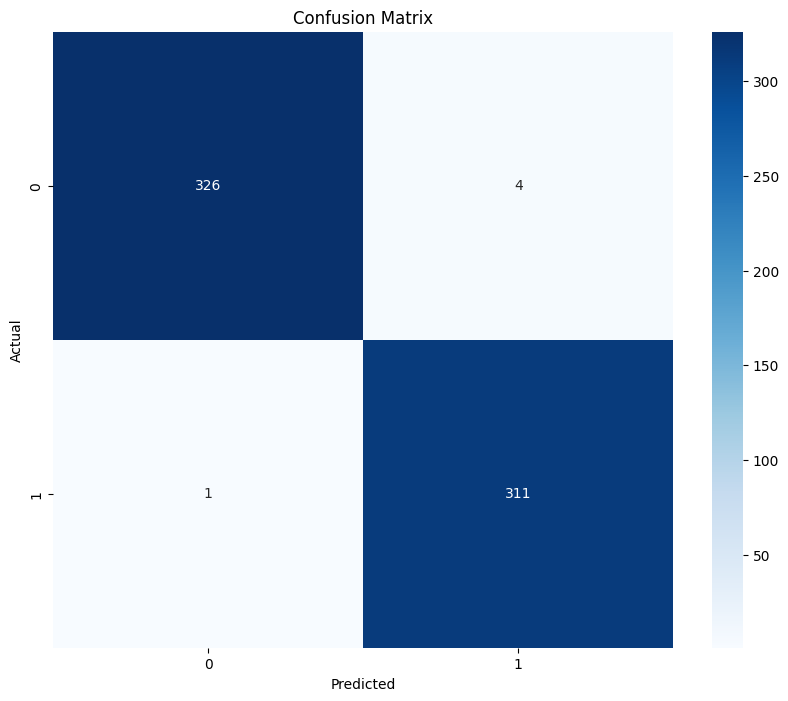

In [14]:
import torch
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ----------------------------
# Optimizer and Loss Function
# ----------------------------
optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = CrossEntropyLoss()

# ----------------------------
# Initialize variables to track highest accuracies
# ----------------------------
best_val_accuracy = 0
best_test_accuracy = 0
best_preds = []
best_labels = []

# ----------------------------
# Training Function
# ----------------------------
def train(model, train_loader, optimizer, loss_fn):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for batch in tqdm(train_loader):
        optimizer.zero_grad()

        pixel_values = batch['pixel_values'].to(device)
        labels = batch['label'].to(device)

        outputs = model(pixel_values=pixel_values.squeeze(1), labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predictions = torch.argmax(F.softmax(logits, dim=1), dim=1)
        correct_predictions += (predictions == labels).sum().item()
        total_predictions += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy

# ----------------------------
# Evaluation Function
# ----------------------------
def evaluate(model, test_loader):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['label'].to(device)

            outputs = model(pixel_values=pixel_values.squeeze(1), labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            predictions = torch.argmax(F.softmax(logits, dim=1), dim=1)

            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy, all_preds, all_labels

# ----------------------------
# Training Loop
# ----------------------------
for epoch in range(5):  # Update epochs as needed
    train_loss, train_accuracy = train(model, train_loader, optimizer, loss_fn)
    print(f"Epoch {epoch + 1} - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")

    val_accuracy = train_accuracy  # Placeholder for actual validation logic
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy

    test_loss, test_accuracy, preds, labels = evaluate(model, test_loader)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        best_preds = preds
        best_labels = labels

# ----------------------------
# Final Evaluation Metrics
# ----------------------------
print(f"\nHighest Validation Accuracy Achieved: {best_val_accuracy * 100:.2f}%")
print(f"Highest Test Accuracy Achieved: {best_test_accuracy * 100:.2f}%\n")

# Classification Report
print("Classification Report:")
print(classification_report(best_labels, best_preds))

# Confusion Matrix
conf_mat = confusion_matrix(best_labels, best_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
